In [57]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d
from federpy.federpy import FederPy
pd.set_option('display.max_colwidth', 200)  # Adjust the width as needed
import faiss

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/DhunganaKB/customchat/main/VectorIndexSearch/TextClassification_Indexing.csv')

In [4]:
df = df.reset_index(drop=True)

In [5]:
df.head()

,Topic,Sentence
0,Soccer World Cup 2020,"The 2020 FIFA World Cup, a globally anticipated event, brought together nations from around the world."
1,Soccer World Cup 2020,"Hosted in multiple cities, the 2020 Soccer World Cup was a month-long celebration of the beautiful game."
2,Soccer World Cup 2020,"It featured the world's top soccer teams, each vying for the coveted championship title in the Soccer World Cup."
3,Soccer World Cup 2020,"With palpable anticipation, fans from diverse backgrounds united to support their respective nations in the Soccer World Cup."
4,Soccer World Cup 2020,"The matches were held in state-of-the-art stadiums, showcasing the pinnacle of soccer infrastructure in the Soccer World Cup."


In [56]:
df.shape

(109, 3)

### Creating Embedding Vectors

In [7]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [8]:
sentences = list(df['Sentence'])
sentence_embeddings = model.encode(sentences)
embedding_dimension = sentence_embeddings.shape[1]
print(embedding_dimension)

768


In [10]:
index=faiss.IndexFlatL2(embedding_dimension)
print(index.ntotal, index.is_trained)
## now adding embedding vector in sentence embeddings
index.add(sentence_embeddings)
print(index.ntotal)

0 True
109


In [11]:
k=3
xq=model.encode(['I would like to know about Nobel Prize from 2020'])

D, I = index.search(xq, k)  # search
print(I)

[[20 28 22]]


In [15]:
df.iloc[I[0]]

,Topic,Sentence
20,Nobel Prize 2020,"The Nobel Prize, one of the world's most prestigious awards, recognized exceptional achievements across multiple fields in 2020."
28,Nobel Prize 2020,The Nobel Prize in 2020 celebrated accomplishments and served as a reminder of the potential for positive change and innovation across the world.
22,Nobel Prize 2020,"In 2020, the Nobel Prize awarded laureates in Physics, Chemistry, Medicine, Literature, and Peace for their remarkable accomplishments."


##### Without using faiss library

In [19]:
# IndexFlatL2 -> Flat index with L2 distance (Eculidian distance)
# IndexFlatIP -> Flat index with IP (Inner Product)

In [20]:
### Euclidian distance

In [21]:
distance=[]

for sub_array in sentence_embeddings:
    distance.append(euclidean(sub_array, xq[0]))

In [22]:
# finding the index of smallest values

def finding_index_smallvalue(lst, k):
    indexed_xx = list(enumerate(lst))

    # Sort the list of tuples based on the values (ascending order)
    sorted_xx = sorted(indexed_xx, key=lambda x: x[1])

    # Get the indices of the smallest three numbers
    smallest_indices = [i for i, value in sorted_xx[:k]]

    return smallest_indices

In [23]:
II=finding_index_smallvalue(distance, 3)
print(II)

[20, 28, 22]


In [60]:
len(sentence_embeddings[0])

768

In [39]:
# We get the same index

Text(0, 0.5, 'X2')

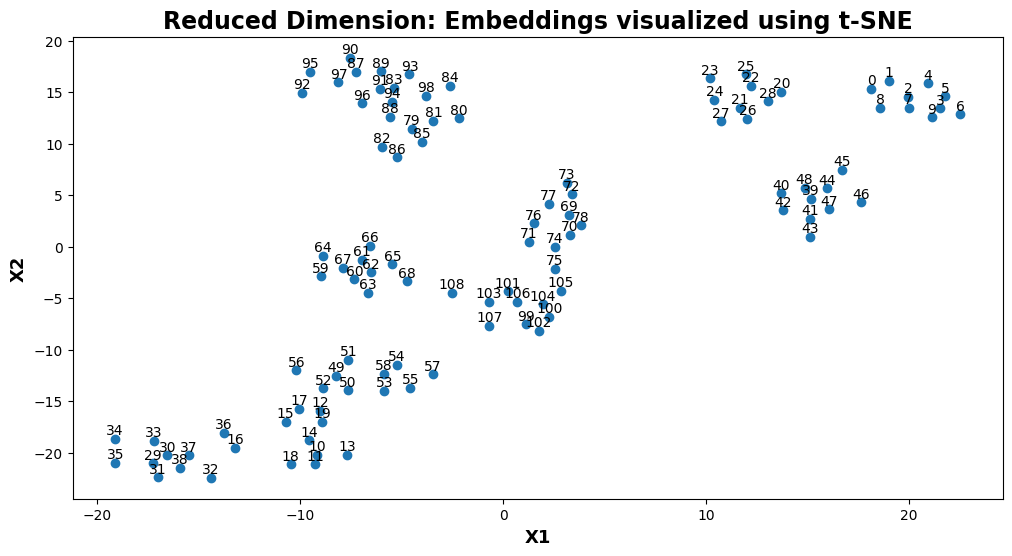

In [26]:
plt.rcParams['figure.figsize'] = (12, 6) 

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)

vis_dims2 = tsne.fit_transform(sentence_embeddings)

x_values = [x for x,y in vis_dims2]
y_values = [y for x,y in vis_dims2]

plt.scatter(x_values, y_values)
for i, (x, y) in enumerate(zip(x_values, y_values)):
    plt.annotate(str(i), (x, y), textcoords="offset points", xytext=(0, 3), ha='center')

plt.title("Reduced Dimension: Embeddings visualized using t-SNE", size=17, fontweight="bold")
plt.xlabel('X1',size=13, fontweight="bold")
plt.ylabel('X2',size=13, fontweight="bold")

#### With inner product

In [27]:
## With Inner Product

index1=faiss.IndexFlatIP(embedding_dimension)
index1.add(sentence_embeddings)
D, I = index1.search(xq, k)  # search
print(I)

[[20 28 22]]


In [28]:
distance1=[]

for sub_array in sentence_embeddings:
    distance1.append(np.inner(sub_array, xq[0]))

In [29]:
# finding the index of largest values

def finding_index_largevalue(lst, k):
    indexed_xx = list(enumerate(lst))

    # Sort the list of tuples based on the values (ascending order)
    sorted_xx = sorted(indexed_xx, key=lambda x: x[1], reverse=True)

    # Get the indices of the smallest three numbers
    largest_indices = [i for i, value in sorted_xx[:k]]

    return largest_indices

In [30]:
finding_index_largevalue(distance1, 3)

[20, 28, 22]

### Inverted File Index (IVF)

In [31]:
len(df['Topic'].unique())

11

In [34]:
nlist=11
quantizer = faiss.IndexFlatIP(embedding_dimension)
index = faiss.IndexIVFFlat(quantizer, embedding_dimension, nlist)
print(index.ntotal, index.is_trained)

0 False


In [35]:
index.train(sentence_embeddings)  # we must train the index to cluster into cells
index.add(sentence_embeddings)
index.nprobe=3
D, I = index.search(xq,3)
print(I)

[[20 28 22]]


In [36]:
## Let's visualize the partition

In [38]:
km_model = KMeans(n_clusters = nlist, init ='k-means++', random_state = 42)
y = km_model.fit_predict(sentence_embeddings)
df['Cluster']=y

c:\Users\kbdhu\anaconda3\envs\langchain\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [44]:
## Getting Projected Centroids

In [45]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims2 = tsne.fit_transform(sentence_embeddings)

x = [x for x,y in vis_dims2]
y = [y for x,y in vis_dims2]

palette = sns.color_palette("husl", nlist).as_hex()

lst=[]
for category, color in enumerate(palette):
    xs = np.array(x)[df.Cluster==category]
    ys = np.array(y)[df.Cluster==category]
    #plt.scatter(xs, ys, color=color, alpha=0.3, s=50)

    avg_x = xs.mean()
    avg_y = ys.mean()

    lst.append([avg_x, avg_y])
    
lst=np.array(lst)


Text(0, 0.5, 'X2')

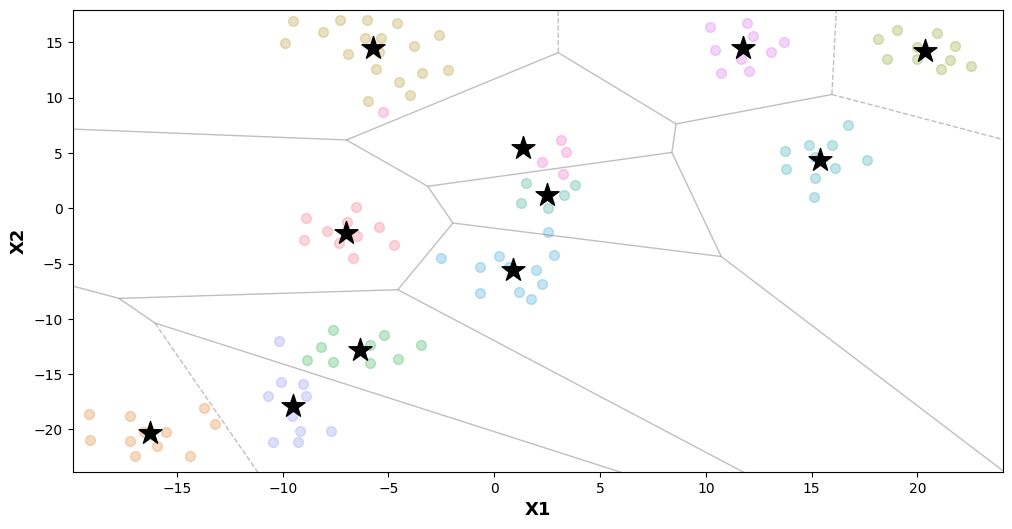

In [46]:
vor = Voronoi(lst)

# Plot Voronoi diagram
voronoi_plot_2d(vor, show_vertices=False, show_points=False, line_colors='gray', line_width=1, line_alpha=0.5)

palette = sns.color_palette("husl", nlist).as_hex()

#lst=[]
for category, color in enumerate(palette):
    xs = np.array(x)[df.Cluster==category]
    ys = np.array(y)[df.Cluster==category]
    plt.scatter(xs, ys, color=color, alpha=0.3, s=50)

    avg_x = xs.mean()
    avg_y = ys.mean()

#    lst.append([avg_x, avg_y])
    
    plt.scatter(avg_x, avg_y, marker='*', color='black', s=300)

# plt.xlim(-120,120)

#plt.title("Reduced Dimension: Embeddings visualized using t-SNE", size=17, fontweight="bold")
plt.xlabel('X1',size=13, fontweight="bold")
plt.ylabel('X2',size=13, fontweight="bold")

#### Visualize Partition using Federpy

In [47]:
## For visualization of 
nlist=20
index = faiss.index_factory(embedding_dimension, 'IVF%s,Flat' % nlist)
index.train(sentence_embeddings)
index.add(sentence_embeddings)
index.nprobe = 5
faiss.write_index(index, 'faiss_ivf_flat_sample.index')

In [48]:
ivfflatSource = 'faiss'
ivfflatIndexFile = 'faiss_ivf_flat_sample.index'


In [51]:
federPy_ivfflat = FederPy(ivfflatIndexFile, ivfflatSource)

In [52]:
federPy_ivfflat.overview()

In [53]:
federPy_ivfflat.searchById(22)

In [54]:
#federPy_ivfflat.setSearchParams({"k": 4, "nprobe": 5}).searchRandTestVec()

In [55]:
federPy_ivfflat.setSearchParams({"k": 3, "nprobe": 5}).searchByVec(xq[0])